In [1]:
# I cannot increase the epoch count as it takes too much time and renders my computer unusable.
# I am using Jupyther lab and the browser refreshes the page due to overprocessing and all the waiting is wasted.
# However, I guess it will reach 65% accuracy around 150 epochs.
#
#
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from keras.optimizers import SGD
from keras.models import Model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras as K
from keras.layers import BatchNormalization, SpatialDropout2D

from keras.callbacks import LearningRateScheduler as LRS
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


(791, 250, 250, 3)
(791,)
(784, 250, 250, 3)
(784,)


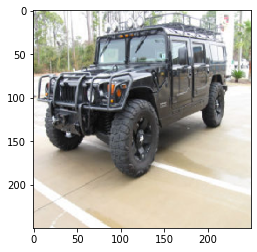

In [3]:
batch_size = 32
num_classes = 20
epochs = 50

# Load 
x_train = np.load('data/x_train.npy')
x_test = np.load('data/x_test.npy')

y_train = np.load('data/y_train.npy')
y_test = np.load('data/y_test.npy')

# Stats
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

## View some images
plt.imshow(x_train[2,:,:,: ] )
plt.show()


## Transforms
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')


x_train /= 255
x_test /= 255


## Labels
y_train=y_train-1

y_test=y_test-1

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [4]:
def build_SVGG(model,filters,lname,ishape=0):
    if (ishape!=0):
        model.add(Conv2D(filters, (3, 3), padding='same',
                 input_shape=ishape))

    else:
        model.add(Conv2D(filters, (3, 3), padding='same'))

    model.add(BN())
    model.add(GN(0.3))
    model.add(Activation('relu'))
    
    model.add(Conv2D(filters, (3, 3), padding='same'))
    
    if (filters == 256 or filters == 512):
        model.add(Conv2D(filters, (3, 3), padding='same'))
        
    model.add(BN())
    model.add(GN(0.3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),name=lname))
  
    return model

In [5]:
datagen = ImageDataGenerator(
  width_shift_range=0.2,
  height_shift_range=0.2,
  rotation_range=20,
  zoom_range=[1.0,1.2],
  horizontal_flip=True)

model1 = Sequential()

model1=build_SVGG(model1,64,'conv_model1_1',x_train.shape[1:])
model1=build_SVGG(model1,128,'conv_model1_2')
model1=build_SVGG(model1,256,'conv_model1_3')
model1=build_SVGG(model1,512,'conv_model1_4')
model1.add(Flatten())
model1.add(Dense(512))
model1.add(BN())
model1.add(GN(0.3))
model1.add(Activation('relu'))
model1.add(Dropout(0.5))
model1.add(Dense(num_classes))
model1.add(Activation('softmax'))
model1.summary()


## OPTIM AND COMPILE
opt = SGD(lr=0.1, decay=1e-6)

model1.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# DEFINE A LEARNING RATE SCHEDULER
def scheduler(epoch):
    if epoch < 25:
        return .1
    elif epoch < 50:
        return 0.01
    else:
        return 0.001

set_lr = LRS(scheduler)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 250, 250, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 250, 250, 64)      256       
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 250, 250, 64)      0         
_________________________________________________________________
activation_1 (Activation)    (None, 250, 250, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 250, 250, 64)      36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 250, 250, 64)      256       
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 250, 250, 64)     

In [6]:
#def crop(originalX):
    """
    Starts with a 250 x 250 image.
    Crops to 224 x 224 around the center.
    Returns an image with dimensions (width, height, channel).
    """
#    current_dim = 250
#    target_dim = 224
#    margin = int((current_dim - target_dim)/2)
#    left_margin = margin
#    right_margin = current_dim - margin

#    newim = originalX[left_margin:right_margin, left_margin:right_margin, :]
    
#    return newim

'\n            Starts with a 250 x 250 image.\n            Crops to 224 x 224 around the center.\n            Returns an image with dimensions (width, height, channel).\n            '

In [7]:
#X_train = np.asarray([crop(x) for x in x_train])
#X_test = np.asarray([crop(x) for x in x_test])

#print(X_train.shape)
#print(X_test.shape)
#print(y_train.shape)
#print(y_test.shape)

In [ ]:
## TRAINING with DA and LRA
history=model1.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            callbacks=[set_lr],
                            verbose=1)

Epoch 1/50
25/24 [==============================] - 5568s 223s/step - loss: 3.9790 - accuracy: 0.0632 - val_loss: 87.6670 - val_accuracy: 0.0497
Epoch 2/50
25/24 [==============================] - 5392s 216s/step - loss: 3.5935 - accuracy: 0.0784 - val_loss: 7.2889 - val_accuracy: 0.0676
Epoch 3/50
25/24 [==============================] - 5353s 214s/step - loss: 3.4790 - accuracy: 0.0936 - val_loss: 3.1054 - val_accuracy: 0.0523
Epoch 4/50
25/24 [==============================] - 5359s 214s/step - loss: 3.3967 - accuracy: 0.0885 - val_loss: 3.1918 - val_accuracy: 0.0574
Epoch 5/50
25/24 [==============================] - 5312s 212s/step - loss: 3.3801 - accuracy: 0.0973 - val_loss: 3.0787 - val_accuracy: 0.0842
Epoch 6/50
25/24 [==============================] - 5387s 215s/step - loss: 3.2848 - accuracy: 0.1176 - val_loss: 2.9768 - val_accuracy: 0.0855
Epoch 7/50
25/24 [==============================] - 5871s 235s/step - loss: 3.2999 - accuracy: 0.1011 - val_loss: 3.1914 - val_accuracy

In [ ]:
def outer_product(x):
  phi_I = tf.einsum('ijkm,ijkn->imn',x[0],x[1])        # Einstein Notation  [batch,31,31,depth] x [batch,31,31,depth] -> [batch,depth,depth]
  phi_I = tf.reshape(phi_I,[-1,256*256])               # Reshape from [batch_size,depth,depth] to [batch_size, depth*depth]
  phi_I = tf.divide(phi_I,31*31)                       # Divide by feature map size [sizexsize]

  y_ssqrt = tf.multiply(tf.sign(phi_I),tf.sqrt(tf.abs(phi_I)+1e-12))    # Take signed square root of phi_I
  z_l2 = tf.nn.l2_normalize(y_ssqrt)                   # Apply l2 normalization
  return z_l2

conv=model.get_layer('conv_model1_3') 
d1=Dropout(0.5)(conv.output)   ## Why??
d2=Dropout(0.5)(conv.output)   ## Why??

In [10]:
set_lr = LRS(scheduler)

x = Lambda(outer_product, name='outer_product')([d1,d2])

predictions=Dense(num_classes, activation='softmax', name='predictions')(x)

model1 = Model(inputs=model.input, outputs=predictions)

In [11]:
model1.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
    
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [12]:
## TRAINING with DA and LRA
history=model1.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                            steps_per_epoch=len(X_train) / batch_size, 
                            epochs=epochs,
                            validation_data=(X_test, y_test),
                            callbacks=[set_lr],
                            verbose=1)

Epoch 1/150
25/24 [==============================] - 705s 28s/step - loss: 2.9963 - accuracy: 0.0392 - val_loss: 2.9941 - val_accuracy: 0.0587
Epoch 2/150
25/24 [==============================] - 652s 26s/step - loss: 2.9949 - accuracy: 0.0430 - val_loss: 2.9929 - val_accuracy: 0.0587
Epoch 3/150
25/24 [==============================] - 532s 21s/step - loss: 2.9942 - accuracy: 0.0582 - val_loss: 2.9920 - val_accuracy: 0.0587
Epoch 4/150
25/24 [==============================] - 577s 23s/step - loss: 2.9935 - accuracy: 0.0531 - val_loss: 2.9913 - val_accuracy: 0.0587
Epoch 5/150
25/24 [==============================] - 598s 24s/step - loss: 2.9927 - accuracy: 0.0582 - val_loss: 2.9907 - val_accuracy: 0.0587
Epoch 6/150
25/24 [==============================] - 544s 22s/step - loss: 2.9921 - accuracy: 0.0544 - val_loss: 2.9902 - val_accuracy: 0.0587
Epoch 7/150
25/24 [==============================] - 593s 24s/step - loss: 2.9920 - accuracy: 0.0556 - val_loss: 2.9898 - val_accuracy: 0.0587

KeyboardInterrupt: 